# **SpooderApp™**
#### *Leveraging business reviews to gain insights for potential improvements.*

## Hypothesis;


Consumer reviews are critical to the success of any business, yet many lack the resources to effectively analyze and act on this feedback. We hypothesize that by leveraging advanced Natural Language Processing (NLP) models, specifically through HuggingFace Transformers and OpenAI LangChain, we can accurately classify customer sentiment and generate actionable recommendations. Our goal is to empower businesses with detailed sentiment analysis and dynamic feedback, enabling them to enhance consumer satisfaction and overall performance.

# **Initialization**

When executing the following code, it is recommended to uncomment any necessary packages not yet installed in your environment.

## Instillations

In [ ]:
# Installing necessary libraries 
# NOTE: Uncomment any libraries not currently present in your environment for
#       initial execution of this notebook

# General utilities
# %pip install pandas --quiet                  # Data manipulation and analysis
# %pip install numpy --quiet                   # Numerical computations
# %pip install scipy --quiet                   # Scientific computing
# %pip install matplotlib --quiet              # Plotting and visualization
# %pip install seaborn --quiet                 # Statistical data visualization
# %pip install tqdm --quiet                    # Progress bar for loops
# %pip install gdown --quiet                   # Downloading files from Google Drive
# %pip install zipfile --quiet                 # Working with zip files
# %pip install json --quiet                    # JSON handling

# Machine Learning & NLP
# %pip install torch --quiet                   # PyTorch for deep learning
# %pip install transformers --quiet            # HuggingFace Transformers
# %pip install datasets --quiet                # HuggingFace Datasets
# %pip install scikit-learn --quiet            # Machine learning tools
# %pip install nltk --quiet                    # Natural Language Toolkit for text processing
# %pip install huggingface-hub --quiet         # Hugging Face Hub for model upload
# %pip install accelerate --quiet              # Accelerate training
# %pip install evaluate --quiet                # Metric evaluation

# Web scraping
# %pip install selenium --quiet                # Browser automation
# %pip install webdriver-manager --quiet       # Manage WebDriver binaries
# %pip install beautifulsoup4 --quiet          # Parsing HTML and XML

# Environment & API
# %pip install python-dotenv --quiet           # Load environment variables
# %pip install langchain --quiet               # OpenAI LangChain for AI models

# Dash (Web App Framework)
# %pip install dash --quiet                       # Dash core components
# %pip install dash-bootstrap-components --quiet  # Dash Bootstrap components

# Plotting & Visualization
# %pip install plotly --quiet                  # Interactive graphing library

## Imports and Dependencies

In [2]:
# General Utilities
import pandas as pd               # Data manipulation and analysis
import os                         # Operating system interfaces
import re                         # Regular expressions
import json                       # JSON handling
import time                       # Time management
import zipfile                    # Working with zip files
import unicodedata                # Unicode character handling
import numpy as np                # Numerical computations
import scipy as sp                # Scientific computing
import gdown                      # Google Drive file download
from tqdm import tqdm             # Progress bar for loops

# Plotting and Visualization
import matplotlib.pyplot as plt   # Plotting and visualization
import seaborn as sns             # Statistical data visualization
import plotly.express as px       # Simple interactive plots
import plotly.graph_objects as go # Detailed interactive plots

# Machine Learning & NLP
import torch                                          # PyTorch for deep learning
from sklearn.model_selection import train_test_split  # Data splitting for training and testing
from datasets import load_metric                      # Compute metrics for NLP models
import nltk                                           # Natural Language Toolkit for text processing
from nltk.corpus import stopwords                     # Stop words for text preprocessing
from nltk.tokenize import word_tokenize               # Tokenization of text
import transformers                                   # HuggingFace Transformers

# Pretrained Model and Tokenization
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer  # DistilBERT model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification         # Auto-tokenizer and model for sequence classification
from transformers import DataCollatorWithPadding                                   # Dynamic padding for batched data
from transformers import TrainingArguments, Trainer                                # Training arguments and trainer
from transformers import pipeline                                                  # Inference pipeline

# Hugging Face Hub
from huggingface_hub import notebook_login  # Login to Hugging Face Hub

# Dataset Formatting
import accelerate                           # Accelerate training
from datasets import Dataset                # Dataset handling
from evaluate import load                   # Metric evaluation

# Web Scraping
from selenium import webdriver                                          # Browser automation
from selenium.webdriver.chrome.service import Service as ChromeService  # WebDriver service for Chrome
from selenium.webdriver.support.ui import WebDriverWait                 # WebDriver wait
from selenium.webdriver.common.by import By                             # Locating elements by attributes
from selenium.webdriver.support import expected_conditions as EC        # Expected conditions for WebDriver waits
from webdriver_manager.chrome import ChromeDriverManager                # Manage WebDriver binaries
from bs4 import BeautifulSoup                                           # Parsing HTML and XML

# Environment & API
from dotenv import load_dotenv              # Load environment variables
from langchain_openai import ChatOpenAI      # OpenAI API for LangChain

# Prompt Template and LLM Chain
from langchain import PromptTemplate        # Prompt template for LangChain
from langchain.chains import LLMChain       # LLM Chain for linking models

# Dash (Web App Framework)
from dash import Dash, dcc, html, callback, callback_context  # Dash core components and callbacks
from dash.dependencies import Input, Output, State            # Dash dependencies for callbacks
from dash.exceptions import PreventUpdate                     # Prevent updates in callbacks
import dash_bootstrap_components as dbc                       # Dash Bootstrap components

# Other
import math                       # Mathematical functions

# **Data**

## Dataset

To prepare our sentiment analysis model, we leveraged the __[Yelp Open Dataset](https://www.yelp.com/dataset)__ to harness existing reviews and ratings. We also explored other available metrics during our EDA, before proceeding to preprocessing and model training.

The [Yelp Open Dataset](#Yelp-Open-Dataset) provided `.json` files with businesses, reviews, and user data from their businesses. Given the lack of image classification, we opted to forego the photo dataset.

#### Retrieval

Due to the large size of the provided files, direct pushes to GitHub were not a viable option. Instead, the files were converted to `.csv` formates (outlined in `Resources/json_convesion_for_gdown.ipynb`) and uploaded to a Google Drive for retrieval through `gdown`.

In [3]:
# Defining a function to access datasets through `gdown`
def fetch_data(set):
    '''
    Fetches a specific dataset from Google Drive using gdown and loads it into a DataFrame.

    Args:
        set (str):      A string representing the dataset to be retrieved. Must be one of the following;
                        'buesiness', 'checkin', 'reviews', 'tip', or 'user'
    
    Returns:
        df (DataFrame): A DataFrame with the retrieved Yelp dataset.

    Raises:
        ValueError:     If an invalid dataset identifier is provided.
        OSError:        If there is an issue with downloading the file or reading the CSV file.
        Exception:      If any other unexpected error occurs during the download or file reading process.
    '''
    # Declaring `url` and `output` for dataset
    match set:
        case 'business':
            url = 'https://drive.google.com/file/d/1t-_rOjZ8oMqPcMJunVaMgY3OEbhnuSCv/view?usp=sharing'
            output = 'Resources/business_dataset.csv'
        case 'checkin':
            url = 'https://drive.google.com/file/d/1_AVWp31ymfvf4QgTiMN_WLAeapfr0omf/view?usp=sharing'
            output = 'Resources/checkin_dataset.csv'
        case 'reviews':
            url = 'https://drive.google.com/file/d/1L8rFjhOQyU90Ycr9t_OLA70vCYM0e7ck/view?usp=sharing'
            output = 'Resources/reviews_dataset.csv'
        case 'tip':
            url = 'https://drive.google.com/file/d/1LMkCi5AFC_58_m7ELmn1hR8YDykuXwqq/view?usp=sharing'
            output = 'Resources/tip_dataset.csv'
        case 'user':
            url = 'https://drive.google.com/file/d/1kQ522qcod7AjD5DO9vj8qFcSKxwJCDrO/view?usp=sharing'
            output = 'Resources/user_dataset.csv'
        case _:
            # Raises
            raise ValueError('Invalid dataset selected, please try again')
    
    # Attempting to fetch dataset
    try:
        # Downloading dataset
        gdown.download(url, output, fuzzy=True, quiet=True)

        # Reading in the dataset
        df = pd.read_csv(output, low_memory=False)

    # Raises
    except ImportError as e:
        raise ImportError(f"Required module not found: {e}")
    except OSError as e:
        raise OSError(f"Error occurred during file operation: {e}")
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")
    
    # Returning the dataset
    return df

#### Fetching and Reading In

*Note: Once the* `fetch_data()` *function has been run for all five (5) datasets, you may comment out those lines of code (annotaed in cell, as well). For any additional executions, use the* `pd.read_csv()` *lines instead.*

In [4]:
# Fetching all datasets (uncomment for first run of code)
# business_df = fetch_data('business')
# checkin_df = fetch_data('checkin')
# reviews_df = fetch_data('reviews')
# tips_df = fetch_data('tip')
# user_df = fetch_data('user')

# Reading in all datasets (uncomment if data already fetched)
business_df = pd.read_csv('./Resources/business_dataset.csv')
checkin_df = pd.read_csv('./Resources/checkin_dataset.csv')
reviews_df = pd.read_csv('./Resources/reviews_dataset.csv')
tips_df = pd.read_csv('./Resources/tip_dataset.csv')
user_df = pd.read_csv('./Resources/user_dataset.csv')

C:\Users\joblu\AppData\Local\Temp\ipykernel_40052\2535528066.py:13: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  user_df = pd.read_csv('./Resources/user_dataset.csv')


## EDA

Each dataset was explored individually before final feature selection and concatenation.

### Business dataset

Contains business data including location data, attributes, and categories.

#### Overview

In [5]:
# Previewing the data
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [6]:
# Confirming additional data details
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       145219 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150273 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


### Checkin dataset

Contains checkins on a business.

#### Overview

In [7]:
# Previewing the data
checkin_df.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [8]:
# Confirming additional data details
checkin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


*Note: We determined this dataset would not add any value to our training data.*

### Reviews dataset

Contains full review text data including the user_id that wrote the review and the business_id the review is written for.

#### Overview

In [9]:
# Previewing the data
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [10]:
# Confirming additional data details
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_id    object
 1   user_id      object
 2   business_id  object
 3   stars        int64 
 4   useful       int64 
 5   funny        int64 
 6   cool         int64 
 7   text         object
 8   date         object
dtypes: int64(4), object(5)
memory usage: 480.0+ MB


#### Na count

In [11]:
# Verifying missing records
reviews_df.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

#### Dropping features:
- **review_id**
- **useful**
- **funny**
- **cool**

In [12]:
# Dropping features
reviews_df.drop(columns = ['review_id','useful','funny','cool'],
                inplace = True)

#### Renaming features:
- **text** to **review**

*Note: This change was reverted before model training.*

In [13]:
# Renaming features
reviews_df.rename(columns = {'text':'review'},inplace = True)

#Confirming columns renamed
reviews_df.head()

,user_id,business_id,stars,review,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


*Dropped:*
- **review_id:** *Eliminated due to low informational value.*
- **useful:** *Eliminated due to low relevance.*
- **funny:** *Eliminated due to low relevance.*
- **cool:** *Eliminated due to low relevance.*

*Essential:*
- **business_id:** *Used as an identifier for concatenation.*
- **stars:** *Used as eventual model target.*
- **review:** *Used as feature for multiple models.*

*Retained:*
- **date:** *Retained for potential time series analysis.*

### Tips dataset

Contains tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

#### Overview

In [14]:
# Previewing the data
tips_df.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [15]:
# Confirming additional data details
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           908915 non-null  object
 1   business_id       908915 non-null  object
 2   text              908901 non-null  object
 3   date              908915 non-null  object
 4   compliment_count  908915 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 34.7+ MB


#### Dropping features:
- **compliment_count**

In [16]:
# Dropping features
tips_df.drop(columns = ['compliment_count'],
             inplace =True)

#### Renaming features:
- **text** to **recommendations**

In [17]:
# Renaming columns
tips_df.rename(columns = {'text':'recommendations'},inplace = True)

#Confirming columns renamed
tips_df.head()

,user_id,business_id,recommendations,date
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09


*Dropped:*
- **compliment_count:** *Eliminated due to low informational value.*

*Retained:*
- **recommendations:** *Retained for potential use as a target variable, since dataset has similar poitential for insights to improve the customer experience.*

### User dataset

Contains user data including the user's friend mapping and all the metadata associated with the user.

#### Overview

In [18]:
# Previewing the data
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,NaN,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


#### Info

In [19]:
# Confirming additional data details
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 333.7+ MB


*Note: We decided this dataset was not to be included in the training data to preserve user anonimity.*

### Concatenation

Merging the `reviews` and `business` data sets to create a single DataFrame to train our model.

In [20]:
# Declaring `data_df` as the merge of `reviews_df` and `business_df`
data_df = reviews_df.merge(business_df,how='left',on = 'business_id')

#### Overview

In [21]:
# Confirming additional data details
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 18 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       object 
 1   business_id   object 
 2   stars_x       int64  
 3   review        object 
 4   date          object 
 5   name          object 
 6   address       object 
 7   city          object 
 8   state         object 
 9   postal_code   object 
 10  latitude      float64
 11  longitude     float64
 12  stars_y       float64
 13  review_count  int64  
 14  is_open       int64  
 15  attributes    object 
 16  categories    object 
 17  hours         object 
dtypes: float64(3), int64(3), object(12)
memory usage: 960.0+ MB


In [22]:
# Previewing the data
data_df.head()

,user_id,business_id,stars_x,review,date,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': ""u'average'"", 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,748 W Starr Pass Blvd,Tucson,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",NaN
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,2549 Banks St,New Orleans,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


#### Na count

In [23]:
# Verifying missing records
data_df.isna().sum()

user_id              0
business_id          0
stars_x              0
review               0
date                 0
name                 0
address          84801
city                 0
state                0
postal_code        972
latitude             0
longitude            0
stars_y              0
review_count         0
is_open              0
attributes      183723
categories         689
hours           398286
dtype: int64

In [24]:
# Verifying missing records as percentages for specific features
# Calculating percentages
na_prcnt = data_df[['attributes','categories','hours']].isna().sum()/data_df.shape[0]*100

# Converting to a DataFrame
nas_df = pd.DataFrame(na_prcnt, columns=['percentage'])

# Transposing values
nas_df = nas_df.transpose()

# Rounding values
nas_df.round(4)

,attributes,categories,hours
percentage,2.6283,0.0099,5.6977


#### Na Count Visualization

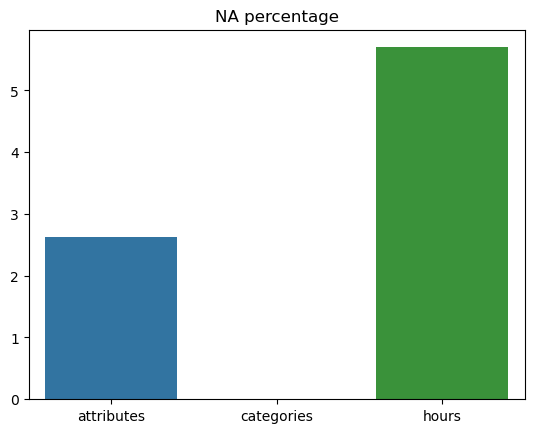

In [26]:
# Generating a bar plot of NA records
sns.barplot(data = nas_df).set_title('NA percentage')

# Saving the figure (commented out after initial save)
plt.savefig('Images/NA_Percentage_Plot.png')

# Displaying the figure
plt.show()

*Note: Ultimately, we decided to drop all three columns.*

#### Dropping features with NA records:
- **attributes**
- **categories**
- **hours**

In [27]:
# Dropping features
data_df.drop(columns = ['attributes','categories','hours'],inplace=True)

In [28]:
# Verifying missing records
data_df.isna().sum()

user_id             0
business_id         0
stars_x             0
review              0
date                0
name                0
address         84801
city                0
state               0
postal_code       972
latitude            0
longitude           0
stars_y             0
review_count        0
is_open             0
dtype: int64

#### Comparing similar features

Exploring the features `stars_x` and `stars_y`.

In [29]:
# Previewing data with different values in both features
data_df.loc[data_df['stars_x'] != data_df['stars_y']][['stars_x','stars_y']].head()

,stars_x,stars_y
2,3,3.5
3,5,4.0
5,1,4.0
6,5,4.5
7,5,3.5


In [30]:
# Previewing values for the same business
data_df.loc[data_df['business_id']=='XQfwVwDr-v0ZS3_CbbE5Xw'][['stars_x','stars_y']].head()

,stars_x,stars_y
0,3,3.0
6080,2,3.0
6911,4,3.0
6927,3,3.0
13378,2,3.0


In [31]:
# Finding the average value for `star_x` for the same business
round(data_df.loc[data_df['business_id']=='XQfwVwDr-v0ZS3_CbbE5Xw']['stars_x'].mean(),2)

3.07

`star_y` seems to represent a business' average rating.

#### Renaming features
- **stars_y** to **stars_avg**
- **stars_x** to **stars**

In [32]:
# Renaming features
data_df.rename(columns={'stars_y':'stars_avg','stars_x':'stars'},inplace = True)

#### Visualization

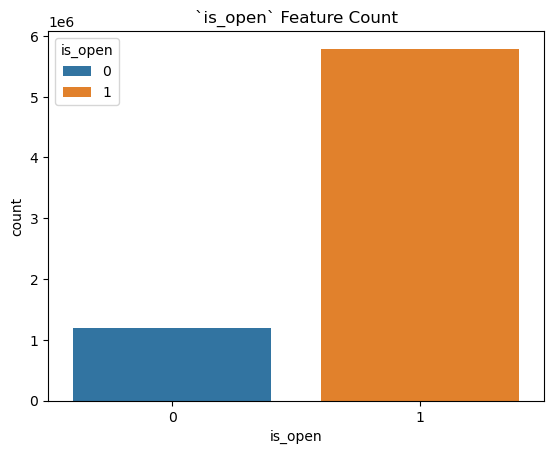

In [34]:
# Declaring plots
fig,ax = plt.subplots()

# Plotting figure
sns.countplot(data_df,
             x='is_open',
             hue = 'is_open',
             ax = ax).set_title('`is_open` Feature Count')

# Saving the figure (commented out after initial save)
plt.savefig('Images/is_open_Feature_Count.png')

# Displaying the figure
plt.show()

#### Dropping features:
- **is_open**

In [35]:
# Dropping features
data_df.drop(columns = ['is_open'],inplace = True)

*Note: We decided to drop this feature due low informational value and feature imbalance.*

### Merging with tips dataset

Exploring to potential gain from merging the tips dataset, since it, too, contains customer recommendations to improve experience.

#### Overview

In [36]:
# Previewing the data
tips_df.head()

,user_id,business_id,recommendations,date
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09


In [37]:
# Confirming additional data details
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          908915 non-null  object
 1   business_id      908915 non-null  object
 2   recommendations  908901 non-null  object
 3   date             908915 non-null  object
dtypes: object(4)
memory usage: 27.7+ MB


In [38]:
# Finding the quantity of unique values in `business_id` in `tips_df`
display(tips_df['business_id'].unique().shape[0])

106193

In [39]:
# Finding the quantity of unique values in `business_id` in `data_df`
data_df['business_id'].unique().shape[0]

150346

Subset of **business_id** in `data_df` not found in `tips_df`

In [40]:
# Declaring `no_tips_df` as a subset of data not found in `tips_df`
no_tips_df = data_df[~data_df['business_id'].isin(tips_df['business_id'])]

# Previewing the data
no_tips_df.head()

,user_id,business_id,stars,review,date,name,address,city,state,postal_code,latitude,longitude,stars_avg,review_count
33,yFuE8SPF-d1GXJUWYgKtzg,X8lfGPagfLzfOsx0k08NRQ,5,Took my vehicle here for some work a few years...,2017-05-13 14:15:29,Landa Muffler & Brake,816 E 4th St,Reno,NV,89512,39.531787,-119.802696,3.5,29
54,dKoIp8vsKFH4cbmGSYy2IQ,0ICfbEImE0gUZc4kSZ7QHg,5,Replaced 2 old 70s lennox with 2 new ones. Th...,2013-11-14 04:58:09,Reliance The Furnace Company,8545 Coronet Road,Edmonton,AB,T6E 4N7,53.499624,-113.456746,2.5,27
56,IMd3NQbclta91pFKk3AJZg,qO9dNNIvNbCBd8ZgjxMxgQ,5,"Farmhouse, rustic, chic.Helpful staff with gre...",2017-04-08 00:33:11,HOME Santa Barbara,14 Parker Way,Santa Barbara,CA,93101,34.414912,-119.694171,4.5,13
76,B6G4f3UX1Z5_CpyV1xXm8Q,AgbRp5NLsP1-J1fdg6Hdcw,5,Awesome little shop. The owner really knows h...,2017-05-13 17:15:09,Hands On Bicycle,1453 Gulf To Bay Blvd,Clearwater,FL,33755,27.963000,-82.777749,5.0,13
86,XN1ms_EBRYMF5GYSjfUHDQ,rJzLJL33mFyrM_90kAQKuw,5,I'm so incredibly happy with our pictures! Ang...,2017-12-02 18:40:48,Angela Clifton Photography,18205 Atherstone Trl,Land O Lakes,FL,34638,28.208604,-82.516107,5.0,9


Quantity of **business_id** in `data_df` not found in `tips_df`

In [41]:
# Counting the unique `business_id`s in `no_tips_df`
not_found = no_tips_df['business_id'].unique().shape[0]

# Printing the result
print(f'Number of business_ids in tips_df not found in data_df: {not_found}')

Number of business_ids in tips_df not found in data_df: 44153


Evidence

In [43]:
# Locating a speciting `business_id` in `tips_df`
tips_df.loc[tips_df['business_id'] == no_tips_df['business_id'].iloc[33]]

,user_id,business_id,recommendations,date


### Merge

In [44]:
# Merging `tips_df` and `data_df` as `test_df`
test_df = pd.merge(tips_df,data_df,
                   on = ['business_id','user_id'],
                   how = 'inner')
                         

#### Overview

In [45]:
# Previewing the data
test_df.head()

,user_id,business_id,recommendations,date_x,stars,review,date_y,name,address,city,state,postal_code,latitude,longitude,stars_avg,review_count
0,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,2,Do not get the schezuan chicken. 1) it's not b...,2018-05-08 01:31:54,Wok Out Restaurant,"1444 S Belcher Rd, Ste B",Clearwater,FL,33764,27.943694,-82.746285,3.5,59
1,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,1,"So sad.....the menu is the same, but the taste...",2015-09-26 21:28:21,Siam Cuisine,265 White Bridge Pike,Nashville,TN,37209,36.143308,-86.858303,4.0,153
2,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,4,Yummie...best thai food in the west side of Na...,2013-11-16 13:28:55,Siam Cuisine,265 White Bridge Pike,Nashville,TN,37209,36.143308,-86.858303,4.0,153
3,trf3Qcz8qvCDKXiTgjUcEg,7Rm9Ba50bw23KTA8RedZYg,"Chili Cup + Single Cheeseburger with onion, pi...",2012-03-13 04:00:52,4,Bottom Line: All your typical Steak n' Shake ...,2010-10-23 21:32:13,Steak ’n Shake,1300 Lemay Ferry Rd,St. Louis,MO,63125,38.531844,-90.288109,2.0,23
4,SMGAlRjyfuYu-c-22zIyOg,kH-0iXqkL7b8UXNpguBMKg,"Saturday, Dec 7th 2013, ride Patco's Silver Sl...",2013-12-03 23:42:15,4,"Patco (sometimes referred to as the ""High Spee...",2013-12-02 13:24:17,PATCO,901 Berlin Rd N,Lindenwold,NJ,08021,39.834038,-75.000662,3.5,74


In [46]:
# Confirming additional data details
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440640 entries, 0 to 440639
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          440640 non-null  object 
 1   business_id      440640 non-null  object 
 2   recommendations  440635 non-null  object 
 3   date_x           440640 non-null  object 
 4   stars            440640 non-null  int64  
 5   review           440640 non-null  object 
 6   date_y           440640 non-null  object 
 7   name             440640 non-null  object 
 8   address          438455 non-null  object 
 9   city             440640 non-null  object 
 10  state            440640 non-null  object 
 11  postal_code      440556 non-null  object 
 12  latitude         440640 non-null  float64
 13  longitude        440640 non-null  float64
 14  stars_avg        440640 non-null  float64
 15  review_count     440640 non-null  int64  
dtypes: float64(3), int64(2), object(11)
me

#### Comparison

Comparing **review** agains **recommendations**

In [47]:
# Previewing the data for the two selected features
test_df[['review','recommendations']].head()

,review,recommendations
0,Do not get the schezuan chicken. 1) it's not b...,Very decent fried chicken
1,"So sad.....the menu is the same, but the taste...",Appetizers.. platter special for lunch
2,Yummie...best thai food in the west side of Na...,Appetizers.. platter special for lunch
3,Bottom Line: All your typical Steak n' Shake ...,"Chili Cup + Single Cheeseburger with onion, pi..."
4,"Patco (sometimes referred to as the ""High Spee...","Saturday, Dec 7th 2013, ride Patco's Silver Sl..."


*Note: The* `data_df` *DataFrame has approximately* ***7 million*** *entries, and the* `tips_df` *DataFrame has about* ***1 million***. *After merging them we end up the a little under* ***500 thousand***. *The comparison above shows little difference between a* ***review*** *from the reviews dataset and a* ***recommendation*** *from the tips dataset. As shown above, we stand to loose a significant amount of data if a merge is performed, we we decided against it.*

### Finalizing data

#### Dropping featires:
- **user_id** *(to preserve user anonymity)*

In [48]:
# Dropping features
data_df.drop(columns = ['user_id'],inplace = True)

#### Overview

In [49]:
# Previewing the data
data_df.head()

,business_id,stars,review,date,name,address,city,state,postal_code,latitude,longitude,stars_avg,review_count
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,3.0,169
1,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,748 W Starr Pass Blvd,Tucson,AZ,85713,32.207233,-110.980864,3.5,47
3,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181
4,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,2549 Banks St,New Orleans,LA,70119,29.962102,-90.087958,4.0,32


In [50]:
# Confirming additional data details
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   business_id   object 
 1   stars         int64  
 2   review        object 
 3   date          object 
 4   name          object 
 5   address       object 
 6   city          object 
 7   state         object 
 8   postal_code   object 
 9   latitude      float64
 10  longitude     float64
 11  stars_avg     float64
 12  review_count  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 693.3+ MB


#### Na count

In [51]:
# Verifying missing records
data_df.isna().sum()

business_id         0
stars               0
review              0
date                0
name                0
address         84801
city                0
state               0
postal_code       972
latitude            0
longitude           0
stars_avg           0
review_count        0
dtype: int64

#### Visualizations

Preparing some visualizations of the final dataset

In [ ]:
# Ratings distribution

In [ ]:
# Review counts per business

In [ ]:
# Business category distribution

# Functions (Pt 1)

The following user-defined functions will be used throughout the sampling, preproccing, an modeling of our data, each developed with their annotated purposes in mind:

| **Function** | **Notes** |
| :--- | :--- |
| `sample_stars()` | Selects subsets of a DataFrame based on user rating value thresholds |
| `remove_accented_chars()` | Removes accented characters from text |
| `clean_text()` | Removes web formatting from text |
| `pre_process_reviews()` | Removes stop words from text |
| `tokenizer_function()` | Tokenizes text |
| `compute_metrics()` | Computes metrics to assist with evaluating model performance |

Functions outlined in more detail below require a DataFrame with the following features:

| **Feature** | **Notes** |
| :--- | :--- |
| `rating` | An int or float column with submitted user review scores |
| `rev_col` | A text column with available reviews |

In [58]:
# Function to select various subsets of data
def sample_stars(df, val):
    '''
    Samples a specific subset of a DataFrame based on the value of the 'stars' column.

    Args:
        df (DataFrame): Any DataFrame with sufficient data.
        val (int):      An integer representing the specific star rating to filter and sample from the DataFrame.

    Returns:
        df (DataFrame): A subset of the input DataFrame filtered by the specified star rating.

    Raises:
        KeyError:       If 'stars' is not a valid column name in the DataFrame.
        TypeError:      If `df` is not a DataFrame or if `val` is not an integer.
        ValueError:     If `val` is not within the acceptable range (1 to 5).
        ValueError:     If there are not enough records in the DataFrame to sample the requested amount.
    '''
    # Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    if 'stars' not in df.columns:
        raise KeyError("Column 'stars' not found in DataFrame.")
    if not isinstance(val, int):
        raise TypeError('The `val` parameter must be passed as an integer.')
    if val < 1 or val > 5:
        raise ValueError('The `val` parameter must be an integer between 1 and 5.')
    
    # Filtering and sampling the DataFrame
    df = df[df['stars'] == val].copy()

    # Sampling the DataFrame based on specified star rating to balance end dataset
    if val >= 4:
        df = df.sample(1000)
    elif val <= 2:
        df = df.sample(1000)
    else:
        df = df.sample(2000)
    df.reset_index(drop=True, inplace=True)
    
    # Retuning the DataFrame
    return df

In [53]:
# Function to remove accented characters
def remove_accented_chars(text):
    '''
    Removes accecnted characters.

    Args:
        text (str):     A corpus of text.

    Returns:
        text (str):     A processed corpus of text.
    '''
    # Removing accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Returning `text`
    return text

In [54]:
# Funtion to remove web formatting
def clean_text(text):
    '''
    Removes Urls',mentions, hashtags, and multiple spaces from text.

    Args:
        text (str):     A corpus of text.
    
    Returns:
        text (str):     A processed corpus of text.
    '''
    # Removing URLs
    text = re.sub(r"http\S+", "", text)
    # Removing mentions
    text = re.sub(r"@\S+", "", text)
    # Removing hashtags
    text = re.sub(r"#\S+", "", text)
    # Removing multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Retuning `text`
    return text

In [55]:
# Funtion to remove stop words from a corups
def pre_process_reviews(reviews):
    '''
    Removes stop words from corpus.

    Args:
        reviews (str):      A corpus of text.
    
    Returns:
        reviews (str):     A processed corpus of text.
    '''
    # Setting stop words
    stop_words = set(stopwords.words('english'))

    # Declaring an empty list for processed reviews
    norm_reviews = []

    # Looping
    for review in tqdm(reviews):
        # Clean text
        review = clean_text(review)
        # remove extra newlines and convert them to spaces
        review = review.translate(review.maketrans("\n\t\r", "   "))
        # lower case
        review = review.lower()
        # remove accents
        review = remove_accented_chars(review)
        # remove special characters
        review = re.sub(r'[^a-zA-Z0-9\s]', '', review, flags=re.I|re.A)
        # remove extra whitespaces
        review = re.sub(' +', ' ', review)
        # remove leading and training whitespaces
        review = review.strip()

        review_tokens = word_tokenize(review)
        review = [w for w in review_tokens if not w in stop_words]
        review = ' '.join(review)

        # Appending to `norm_reviews`
        norm_reviews.append(review)
    
    # Returning `norm_reviews`
    return norm_reviews

In [56]:
# Function to tokenize a corpus
def tokenizer_function(review):
    '''
    Tokenizes corpus
    
    Args:
        reviews (str):              A corpus of text.
    
    Returns:
        return_tensors (pythorch):  A tokenized corpus of text.
    '''
    # Extracting text
    text = review['text']

    # Tokenize text with truncation and padding
    tokenized_inputs = tokenizer(
        text,
        # Truncate to max_length from the right by default
        truncation=True,
        # Pad to the maximum length
        padding="max_length",
        # Maximum sequence length for BERT models
        max_length=512,
        # Assuming you are using PyTorch; change to 'np' if necessary
        return_tensors='pt'
    )

    # Returning `tokenized_inputs`
    return tokenized_inputs

In [67]:
# Load multiple metrics
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

# Function to compute the metrics of our model
def compute_metrics(pred):
    '''
    Computes metrics to assist in evaluating model perfomance.

    Args:
        pred (tuple):   A series representing modeled predictions and a boolian indicator.
    
    Returns:
        return (dict):  A dictionary containing model performance metrics.
    
    Raises:
        TypeError:      If `pred` is not a tuple or if the elements of `pred` are not numpy arrays.
        ValueError:     If the shape of the predictions does not match the shape of the labels.
    '''
    # Raises
    if not isinstance(pred, tuple):
        raise TypeError("The `pred` argument must be a tuple.")
    if not isinstance(pred[0], np.ndarray) or not isinstance(pred[1], np.ndarray):
        raise TypeError("The elements of `pred` must be numpy arrays.")
    if pred[0].shape[0] != pred[1].shape[0]:
        raise ValueError("The number of predictions must match the number of labels.")
    
    # Unpacked tuple
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)

    # Metrics
    # Accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # Precision
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Recall
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    # F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    # Returning a dictionary containing all metrics
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# **Modeling**

## Preparing a subset of data

Due to the imbalance of submitted user ratings, we decided to narrow our training data to reflect a balanced spread of "positive", "neutral", and "negative" reviews. To accomplish this, we selected an equal number of records with 5 or 4 star ratings, 3 star ratings, and 2 or 1 star ratings.

In [59]:
# Declaring subsets of data
sample_5 = sample_stars(data_df,5)
sample_4 = sample_stars(data_df,4)
sample_3 = sample_stars(data_df,3)
sample_2 = sample_stars(data_df,2)
sample_1 = sample_stars(data_df,1)

### Concatenating data samples

In [60]:
# Concatenating sample sets into a single DataFrame
sample_data_df = pd.concat(
    [
        sample_1,
        sample_2,
        sample_3,
        sample_4,
        sample_5
    ], axis=0, ignore_index=True
)

# Confirming total records in `sample_data_df`
sample_data_df.shape

(6000, 13)

In [61]:
# Confirming appropriate quantities of each star values were pulled
sample_data_df['stars'].value_counts()

stars
3    2000
1    1000
2    1000
4    1000
5    1000
Name: count, dtype: int64

### Manual encoding

Our goal was to break down reviews into "positive", "neutral", or "negative" sentiments. As such, we manually encoded the value of `stars` as follows;

| **Stars** | **Label** | **Sentiment Meaning** |
| :--- | :--- | :--- |
| **5** | **2** | "Positive" |
| **4** | **2** | "Positive" |
| **3** | **1** | "Neutral" |
| **2** | **0** | "Negative" |
| **1** | **0** | "Negative" |

In [63]:
# Manually encoding `stars` value to create sentiment labels
sample_data_df['stars']= sample_data_df['stars'].replace(to_replace=[1,2], value=0)
sample_data_df['stars']= sample_data_df['stars'].replace(to_replace=3, value=1)
sample_data_df['stars']= sample_data_df['stars'].replace(to_replace=[4,5], value=2)

In [64]:
# Confirming equal label class counts
sample_data_df['stars'].value_counts()

stars
0    2000
1    2000
2    2000
Name: count, dtype: int64

#### Na count

In [65]:
# Verifying missing records
sample_data_df.isna().sum()

business_id      0
stars            0
review           0
date             0
name             0
address         43
city             0
state            0
postal_code      1
latitude         0
longitude        0
stars_avg        0
review_count     0
dtype: int64

*Note: Since this dataset is for training the sentiment analysis model, only, NA values in fields other than* `stars` *and* `review` *are ultimately irrelevent to the model training. As such, no records were in need of being dropped.*

#### Renaming featires:
- **review** to **text**
- **stars** to **label**

In [66]:
# Renaming features
sample_data_df.rename(columns={'review':'text','stars':'label'},inplace = True)

### Train Test Split

Our sample set was prepared for training with `train_test_split()` set to a `random_state=` of **42**, because life, the universe, and everything.

In [68]:
# Declaring `X` as features
X = sample_data_df['text']
# Declaring `y` as target
y = sample_data_df['label']

# Splitting the data into training and testing sets with a `test_size` of 0.3
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42)

## Building the pipeline

Our approach to sentiment analysis centered around utilizing a BERT-based Transormer. As such, steps were taken to establish, then tune the hyperparameters of, our pipeline.

### Preprocessing

Once split, each dataset was passed through our established preprocessing functions to prepare for model training.

In [69]:
# Preprocessing training reviews
norm_train_reviews = pre_process_reviews(X_train)

# Preprocessing testing reviews
norm_test_reviews = pre_process_reviews(X_test)

100%|██████████| 1800/1800 [00:00<00:00, 4344.65it/s]


In [70]:
# Formatting training target data as a Dataset
train_dataset = Dataset.from_dict({'label':y_train.to_list(),'text':norm_train_reviews})
# Formatting testing target data as a Dataset
test_dataset = Dataset.from_dict({'label':y_test.to_list(),'text':norm_test_reviews})

### Generating the model

Each step below brought us one step closer to building our model, now lovingly referred to as `roberto`.

#### Building the model

Here we set `roberto`'s initial definition.

In [71]:
#Pretrained model
model_checkpoint = 'distilbert-base-uncased'

#Defining label classes
id_to_label = {0:'Negative', 1:'Neutral', 2:'Positive'}
label_to_id = {'Negative':0, 'Neutral': 1,'Positive':2}

#Model definiftion
model = DistilBertForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels = 3,
    id2label = id_to_label,
    label2id =label_to_id 
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Tokenizing

And here we prepared the necessary steps for `roberto`'s tokenization.

In [72]:
#Model tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)
#Padding token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

## Mapping Preprocessed data set to tokinezed data
tokenized_train_dataset = train_dataset.map(tokenizer_function, batched=True)
tokenized_test_dataset = train_dataset.map(tokenizer_function, batched=True)

Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

#### Collator

`roberto` needed a collator, too.

In [73]:
#Dynamic padding
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

#### Training arguments

While not argumentative by nature, `roberto` needed controllable hyperparameters to tune through the training process. Here we did that.

In [74]:
##Trainig arguments hypter-parameters,which will be used to train the model

#Output directory
output_dir = 'model_sentiment'
#Learning Rate
lr = 2e-5
#Batch size
batch_size = 32
#Epochs
EPOCHS = 3

#Training arguments
training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size*2,
    num_train_epochs = EPOCHS,
    weight_decay = 0.01,
    save_strategy = 'epoch',
    evaluation_strategy = 'epoch',
    logging_steps = 10,
    load_best_model_at_end = True,
    # Enable mixed precision
    fp16=True
)

c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Trainer

As we were trained to do, we etablished a proper trainer for `roberto` below.

In [75]:
#Trainer instatiation
trainer = Trainer(
                  model = model,
                  args = training_args,
                  train_dataset = tokenized_train_dataset,
                  eval_dataset = tokenized_test_dataset,
                  tokenizer = tokenizer,
                  compute_metrics = compute_metrics,
                  data_collator = data_collator
)

#### Training

It all came down to this. `roberto`'s moment t make us proud!

*Note: We commented this next cell out seeing as it took six (6) hours to train* `roebrto`.

In [ ]:
# Fine-tuning the model with sample set of balanced data
# (commented out to prevent re-training)

# trained_model_results = trainer.train()

`roberto`... did not make us proud at first...

#### Training and Hypertuning;

Here are the initial and final accuracy values during `roberto`'s development;\
Initial fine-tuning of pretrained model yielded accuracy values of ~40-50%.\
Final yielded accruacy values are around ~81%.

Steps taken to improve accuracy (in something close to resembling order of application);
* Changed pre-trained model from `distilbert-base-uncased` to `MarieAngeA13/Sentiment-Analysis-BERT`
* Adjusted sample sizes of data <br> (from ~100 records total to a balanced sample set of 1000 with equal representation for all ratings) <br> (it would be another iteration before that sample set would be a balanced represntaion of the *labels*, though)
* Updates to text cleaning to include more web-present syntax <br> (eg; mentions, multiple spaces, hashtags, and web address elements) <br> (because reviews aren't literary works, typically)
* Adjustted syntax and arguments of tokenizer function and the application of it
* Adjusted training arguments to better align with our BERT-based model <br> (*spoiler: this gets undone pretty soon after*)
* Added additional metrics for better understanding of neccessary optimization
* Increased sample data size, again, and removed subset step entirely <br> (started at 10,000 only to then decrease that sample size to 600 because of time, but it was still a larger sample than where it started)
* Adjusted batch size and epochs <br> (twice)
* Moved back to `distilbert-base-uncased` and adjusted learning tokenizers, learning rate, logging steps, and such hyperparameters accordingly <br> (because sometimes less Bert is better Bert)
* Bargained with Eldritch beings in the hopes of a single soul buying even just a 10% boost to accuracy <br> (which is to say the sample size was changed to 3,000) <br> (also added and evaluation step to get a better idea of performance)
* Exchanged soul because the deal was pretty tempting <br> (3,000 records had an accuracy of ~78%, so set the model to train overnight with 6,000 records in the hopes of an above 80% result)

In the end, though? Yeah. `roberto` made us ***VERY*** proud!

Copied output from final evaluation;

> {'eval_loss': 0.4815390408039093, 'eval_accuracy': 0.8169047619047619, 'eval_precision': 0.8175331785953032, 'eval_recall': 0.8169047619047619, 'eval_f1': 0.8171466024398222, 'eval_runtime': 1743.5234, 'eval_samples_per_second': 2.409, 'eval_steps_per_second': 0.038, 'epoch': 3.0}


#### Evaluation

How we tested `roberto`'s performance. Don't worry, we saved the best results just above here.

*Note: We commented this out because there are no model metrics to review if the training cell is not run.*

In [76]:
# Evaluate the model (commented out due to trainer already being trained)
# evaluation_metrics = trainer.evaluate()

# Print the final score (commented out due to trainer already being trained)
# print(evaluation_metrics)

#### Saving Model & Tokenizer

Once we had an adequately trained `roberto`, we saved out model off for later fetching.

*Note: We commented this out because there is no model to save if the training cell is not run.*

In [77]:
# Saving the model and toekenizer
# (commented out to prevent overwriting, # fetching handled through `gdown` and `zipfile`)
# trainer.save_model(model_path)

# tokenizer.save_pretrained(tokenizer_path)

#### Fetching and unzipping model

So... Long story short, training a model on six-thousand (**6,000**) records makes for a sizable directory. Much as we circumnavicated Git's file size push restrictions with the datasets, we utlized `gdown` to fetch our model from being stored on Google Drive.

*Note: The cell below is only necessary to be run during this notebook's first execution. It may be commented out for any subsequent execution.*

In [78]:
# Fetching model through `gdown`
url = 'https://drive.google.com/file/d/1tzYRkjv3wWpfg21pJ02SEYNXEcj-TVH3/view?usp=sharing'
output = 'Resources/Sentiment_Analysis.zip'
# Download model
gdown.download(url, output, fuzzy=True, quiet=False)

# Extracting model
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('./Sentiment_Analysis')

Downloading...
From (original): https://drive.google.com/uc?id=1tzYRkjv3wWpfg21pJ02SEYNXEcj-TVH3
From (redirected): https://drive.google.com/uc?id=1tzYRkjv3wWpfg21pJ02SEYNXEcj-TVH3&confirm=t&uuid=02b25855-bfc5-496e-9eb0-9294c359f7ca
To: c:\Users\joblu\Documents\Columbia\Activities\Assignments\Module 23-24 Group Project\AI_Project_3_Group_01\Resources\Sentiment_Analysis.zip
100%|██████████| 247M/247M [00:05<00:00, 42.9MB/s] 


#### Paths

Once saved or fetched, pathing to `roberto` is necessary for later use. Here we set our paths.

*Note: If you unzip a file, it puts itself in a folder named for its zip, so... Yeah, the redundant filepath is a byproduct of default zip behavior.*

In [79]:
# Declaring the model path
model_path = 'Sentiment_Analysis/Sentiment_Analysis/model'

# Declaring the tokenizer path
tokenizer_path =  'Sentiment_Analysis/Sentiment_Analysis/tokenizer'

### The end result

Finally complete, `roberto` comes together with all the necessary pieces of its pipeline in place. **Behold!** `roberto`!

In [80]:
#Loading Model
model = DistilBertForSequenceClassification.from_pretrained(model_path)
#Loading Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)

# Because of his dedication, our exhaustion which led us (Vanessa) to mispronunciate his name him honor of our TA Alberto Aigner 
# we have named our Pipeline 'roberto'
roberto = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)

# Functions (Pt 2)

While trained on Yelp! data, and developed for Google Reviews, the goal of the application is to be as univerally applicable to business reviews as possible - regardless of the source. The following functions were developed with their annotated purposes in mind:

| **Function** | **Notes** |
| :--- | :---|
| `apply_roberto()` | Generates sentiment analysis for reviews in a given dataset, and a confidence in that sentiment |
| `business_names_list()` | Generates a list of unique business names from a given dataset |
| `reviews_list()` | Generates a list of all reviews submitted to a business for all its locations |
| `general_sentiment()` | Classifies the general sentiment for a business' reviews and provides a mean confidence in that sentiment <br> *Note: To be run after a DataFrame has been passed through* `apply_roberto()` |

Functions outlined in more detail below require a DataFrame with the following features:

| **Feature** | **Notes** |
| :--- | :--- |
| `bus_name_col` | A text column with the name of a business |
| `bus_add` | A text column with the street address of a business' location |
| `rev_col` | A text column with available reviews |
| `sent_lbl` | A text column with the generated sentiment classification <br> *Note: Generated through* `apply_roberto()` |
| `sent_scr` | A text column with the generated sentiment classification <br> *Note: Generated through* `apply_roberto()` |

In [81]:
# Function to apply `roberto` to any DF
def apply_roberto(df,rev_col):
    '''
    Applies the `roberto` model to generate sentiment analysis for the reviews in a DataFrame.

    Args:
        df (DataFrame):     Any DataFrame with sufficient data.
        rev_col (str):      A string with the feature name that contains the review text.
    
    Returns:
        df (DataFrame):     The same DataFrame with the appended sentiments and confidence scores.
    
    Raises:
        KeyError:  If `rev_col` is not a valid column name in the DataFrame.
        TypeError: If `df` is not a DataFrame or if `review_col` is not a string.
    '''
    #Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    if not isinstance(rev_col, str):
        raise TypeError('The `rev_col` parameter must be passed as a string.')
    if rev_col not in df.columns:
        raise KeyError(f"Column '{rev_col}' not found in DataFrame.")
    
    # Initializing features for results
    df['sent_label'] = ''
    df['sent_score'] = 0.0

    # Iterating through `df`
    for index,row in df.iterrows():
        # Setting review text as `text`
        text = row[rev_col]
        # Generating results for a given review
        result = roberto(text, truncation=True)[0]
        # Appending the sentiment label
        df.at[index, 'sent_label'] = result['label']
        #Appending the sentiment score
        df.at[index, 'sent_score'] = result['score']
    
    # Returning `df`
    return df

In [82]:
# Function to retrieve unique business names
def business_names_list(df, bus_name_col):
    '''
    Places unique names from a list of businesses into a list.

    Args:
        df (DataFrame):     Any DataFrame with sufficient data.
        bus_name_col (str): A string with the feature name that contains the business name.

    Returns:
        names (list):       A list of strings with only unique values.

    Raises:
        KeyError:           If `bus_name` is not a valid column name in the DataFrame.
        TypeError:          If `df` is not a DataFrame or if `bus_name` is not a string.
    '''
    # Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    if not isinstance(bus_name_col, str):
        raise TypeError('The `bus_name` parameter must be passed as a string.')
    if bus_name_col not in df.columns:
        raise KeyError(f"Column '{bus_name_col}' not found in DataFrame.")

    # Generating a list of business names
    names = df[bus_name_col].unique().tolist()
    
    # Returning the list
    return names

In [83]:
# Function to retrieve all reviews
def reviews_list(df, bus_name_col, bus_name, bus_add, rev_col):
    '''
    Places all reviews for a given business into a list, attributing each review to its specific location.

    Args:
        df (DataFrame):     Any DataFrame with sufficient data.
        bus_name_col (str): A string with the feature name that contains the business name.
        bus_name (str):     A string of a specific business' name for which to map the locations.
        bus_add (str):      A string with the feature name that contains the business street address.
        rev_col (str):      A string with the feature name that contains the review text.

    Returns:
        reviews (list):     A list of strings with all the reviews for a given business.

    Raises:
        KeyError:           If any passed str is not a valid column name in the DataFrame, or if `bus_name` is not a value in `bus_name_col`.
        TypeError:          If `df` is not a DataFrame  if and feature is not a string, or if `bus_name` is not a string.
    '''
    # Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    for param, name in zip(
        [bus_name_col, bus_add, rev_col],
        ['bus_name_col', 'bus_add', 'rev_col']
    ):
        if not isinstance(param, str):
            raise TypeError(f"The '{name}' parameter must be passed as a string.")
        if param not in df.columns:
            raise KeyError(f"Column '{param}' not found in DataFrame.")
    if not isinstance(bus_name, str):
        raise TypeError('The `bus_name` parameter must be passed as a string.')
    if bus_name not in df[bus_name_col].values:
        raise KeyError(f"Value '{bus_name}' not found in column '{bus_name_col}'.")
    
    # Filtering `df`
    filtered_df = df[[bus_add, rev_col]][df[bus_name_col] == bus_name].copy()

    # Handling missing or empty reviews
    filtered_df[rev_col] = filtered_df[rev_col].fillna('No review provided.')

    # Creating a list of all reviews
    reviews = filtered_df[bus_add] + ':\n' + filtered_df[rev_col] + '\n\n'

    # Converting to a list
    reviews = reviews.to_list()

    # Returning reviews
    return reviews

In [84]:
# Function to generalize the overall sentiment
def general_sentiment(df, bus_name_col, bus_name, sent_lbl, sent_scr):
    '''
    Compares the total positive, negative, and neutral reviews to classify an overall sentiment.

    Note:
        To be run after passing a DataFrame through `apply_roberto()`.

    Args:
        df (DataFrame):     Any DataFrame with sufficient data.
        bus_name_col (str): A string with the feature name that contains the business name.
        bus_name (str):     A string of a specific business' name for which to map the locations.
        sent_lbl (str):     A string with the feature name that contains the modeled sentiment label.
        sent_scr (str):     A string with the feature name that contains the modeled sentiment confidence.

    Returns:
        gen_sent (str):     A string with the overall sentiment, and the model's mean confidence in that classification.
    
    Raises:
        KeyError:           If any passed str is not a valid column name in the DataFrame, or if `bus_name` is not a value in `bus_name_col`.
        TypeError:          If `df` is not a DataFrame  if and feature is not a string, or if `bus_name` is not a string.
    '''
    # Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    for param, name in zip(
        [bus_name_col, sent_lbl, sent_scr],
        ['bus_name_col', 'sent_lbl', 'sent_scr']
    ):
        if not isinstance(param, str):
            raise TypeError(f"The '{name}' parameter must be passed as a string.")
        if param not in df.columns:
            raise KeyError(f"Column '{param}' not found in DataFrame.")
    if not isinstance(bus_name, str):
        raise TypeError('The `bus_name` parameter must be passed as a string.')
    if bus_name not in df[bus_name_col].values:
        raise KeyError(f"Value '{bus_name}' not found in column '{bus_name_col}'.")
    
    # Filtering `df`
    filtered_df = df[[sent_lbl, sent_scr]][df[bus_name_col] == bus_name].copy()

    # Converting `sentiment` to lower case
    filtered_df[sent_lbl] = filtered_df[sent_lbl].str.lower()

    # Calculating total `positive` sentiment
    pos = filtered_df.loc[filtered_df[sent_lbl] == 'positive'].shape[0]
    # Calculating total `neutral` sentiment
    ntrl = filtered_df.loc[filtered_df[sent_lbl] == 'neutral'].shape[0]
    # Calculating total `negative` sentiment
    neg = filtered_df.loc[filtered_df[sent_lbl] == 'negative'].shape[0]

    # Match case to generate general sentiment
    match (pos, ntrl, neg):
        case (p, n, ng) if p > n > ng:
            sent = 'highly positive'
        case (p, n, ng) if p > n + ng:
            sent = 'strongly positive'
        case (p, n, ng) if p + n > ng:
            sent = 'moderately positive'
        case (p, n, ng) if p < n > ng:
            sent = 'generally neutral'
        case (p, n, ng) if p < n < ng:
            sent = 'moderately negative'
        case (p, n, ng) if p + n < ng:
            sent = 'strongly negative'
        case (p, n, ng) if ng > n > p:
            sent = 'highly negative'
        case (p, n, ng) if p == n == ng:
            sent = 'perfectly neutral'
        case _:
            sent = 'undetermined'
    
    # Calculate the mean confidence
    conf = filtered_df[sent_scr].mean() * 100

    # Generating the final sentiment
    if pos + ntrl + neg != 0:
        # Concatenating sentiment and confidence
        gen_sent = f'The general sentiment is {sent}, with an average confidence of {conf:.1f}%.'
    else:
        # When no sentment available due to no reviews
        gen_sent = 'Cannot confirm sentiment due to a lack of reviews.'

    # Returning sentiment
    return gen_sent

# Web Scraping

Angelica, I'm leaving this and the bottom on you for refactoring... I'm so sorry. I trust you with your code more than me.

In [2]:
# define a function to create df with the business name, avg rating and address of each location
def business_Overview(business_name,avg_rating,address1,lat,long,df):
    df['bus_id'] = business_name
    df['avg_rating'] = avg_rating
    address_list = address1.split(',')
    df['bus_add'] = address_list[0]
    df['bus_city'] = address_list[1]
    df['lat'] = lat
    df['lon'] = long
    return df

# import business df with Google Maps url for web scrapping
url_df = pd.read_csv('Resources/business_urls.csv')

# pass the first 11 businesses from the business_urls file
url_df = url_df.head(11)

# create list of urls and lat/long for web scrapping step 
url = url_df['url'].tolist()
lat = url_df['lat'].astype(str).tolist()
long = url_df['long'].astype(str).tolist()

# initiate driver
driver = webdriver.Chrome(service = ChromeService(ChromeDriverManager().install()))

#create for loop to parse through the different locations in the url list above
c = 0
df_list = []

for i in range(0,len(url)):
    c += 1
    driver.get(url[i])
    time.sleep(5)

    # get parameters needed for business overview function
    response = BeautifulSoup(driver.page_source, 'html.parser')
    business_name = response.find('h1',class_='DUwDvf lfPIob').text
    avg_rating = response.find('div',class_='fontDisplayLarge').text
    address = response.find('div',class_= 'rogA2c').text
    lat_ = lat[i]
    long_ = long[i]
    
    # navigate to Reviews tab
    driver.find_element(By.CLASS_NAME, "RWPxGd").click()
    time.sleep(3)

    #Find the total number of reviews
    total_number_of_reviews = driver.find_element('xpath','//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[2]/div/div[2]/div[3]').text.split(" ")[0]
    total_number_of_reviews = int(total_number_of_reviews.replace(',','')) if ',' in total_number_of_reviews else int(total_number_of_reviews)

    total_number_of_reviews = 50

    #Find scroll layout
    scrollable_div = driver.find_element('xpath','//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')

    #Scroll as many times as necessary to load all reviews - 10 reviews shown at a time
    for i in range(0,(round(total_number_of_reviews/10 - 1))):
        driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)
        time.sleep(1)

    # #parse HTML and Data Extraction
    # loop over the number of reviews 
    next_item = driver.find_elements('xpath','//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[9]/div[1]/div/div')
    time.sleep(3)

    #expand review by click on 'more' button
    for i in next_item:
        button = i.find_elements(By.TAG_NAME,'button')
        for m in button:
            if m.text == "More":
                m.click()
        time.sleep(5)

    # parse through the HTML 
    response = BeautifulSoup(driver.page_source, 'html.parser')
    reviews = response.find_all('div',class_ = 'jftiEf')

    # define function to gather relevant data from the reviews result set obtained by parsing through HTML
    def get_review_summary(result_set):
            rev_dict = {
                'review' : [],
                'rating' : []}

            for result in result_set:
                #review_name = result.find(class_='d4r55').text
                review_text = result.find('span',class_='wiI7pd').text
                review_rating = result.find(class_='kvMYJc')['aria-label']
                review_rating = review_rating[0]
                rev_dict['review'].append(review_text)
                rev_dict['rating'].append(review_rating)
            
            import pandas as pd
            return(pd.DataFrame(rev_dict))
    
    # gather relevant data using newly created function above 
    summary_df = get_review_summary(reviews)

    # access the number of locations in the url list
    df = business_Overview(business_name,avg_rating,address,lat_,long_,summary_df)

    # append df to df list 
    df_list.append(df)


#concat list of data frames into one 
spooder_df = pd.concat(df_list, ignore_index=True)
spooder_df


,review,rating,bus_id,avg_rating,bus_add,bus_city,lat,lon
0,"The cakes are beautiful and delicious, but you...",5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625
1,The entire experience was excellent: well-brew...,5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625
2,"Everything was great.\n\nFood, service, and th...",5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625
3,The soup is amazing. My family likes the Itali...,5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625
4,Absolutely love Dulce de Leche Bakery in Jerse...,5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625
...,...,...,...,...,...,...,...,...
545,"Absolutely amazing. We ordered from their ""fa...",5,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973
546,This place’s onion rings are my comfort food (...,5,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973
547,Very good chain restaurant the food is always ...,4,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973
548,Loaded sweet potato and the rolls are the best...,5,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973


In [3]:
# Exporting spooder_df for later use (commented out because `.csv` in `Resources/`)
spooder_df.to_csv('./Resources/spooder.csv')

## Apply the Sentiment Analysis Model to the Web Scrapped Data

In [11]:
# apply Roberto to web scrapping dataframe with Google Reviews
roberto_df = apply_roberto(spooder_df,'review')
roberto_df

,review,rating,bus_id,avg_rating,bus_add,bus_city,lat,lon,sent_label,sent_score
0,"The cakes are beautiful and delicious, but you...",5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625,Positive,0.763528
1,The entire experience was excellent: well-brew...,5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625,Positive,0.889528
2,"Everything was great.\n\nFood, service, and th...",5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625,Positive,0.810901
3,The soup is amazing. My family likes the Itali...,5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625,Positive,0.791038
4,Absolutely love Dulce de Leche Bakery in Jerse...,5,Dulce De Leche Bakery,4.7,376 Central Ave,Jersey City,40.7476428,-74.0527625,Positive,0.932732
...,...,...,...,...,...,...,...,...,...,...
545,"Absolutely amazing. We ordered from their ""fa...",5,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973,Positive,0.650678
546,This place’s onion rings are my comfort food (...,5,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973,Neutral,0.456376
547,Very good chain restaurant the food is always ...,4,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973,Positive,0.725514
548,Loaded sweet potato and the rolls are the best...,5,Texas Roadhouse,4.4,2105 NJ-35 Suite 103,Holmdel,40.412299,-74.145973,Negative,0.718005


In [12]:
# Exporting roberto_df for later use (commented out because `.csv` in `Resources/`)
roberto_df.to_csv('./Resources/roberto.csv')

In [13]:
# run function to get general sentiment per business to be used as input into chatgpt model 
general_sentiment_web_scrapping = general_sentiment(roberto_df, 'bus_id', 'Dulce de Leche Bakery', 'sent_label', 'sent_score')
general_sentiment_web_scrapping

'The general sentiment is highly positive, with an average confidence of 75.4%.'

In [14]:
# run function to add all reviews of a given business as a list
review_list = reviews_list(roberto_df, 'bus_id', 'Dulce de Leche Bakery', 'bus_add', 'review')
review_list[:10]

['55 W Palisade Ave:\nAwesome bakery right in the heart of Englewood. They are very busy, especially on weekends and holidays, but the staff keep the line moving quickly. All of their pastries are delicious, and their coffee is just right. The inside of the establishment is quite beautiful as well, with a minimalist open air decor and aesthetic. Highly recommend a visit!\n\n',
 '55 W Palisade Ave:\nLove! Love! Love! My favorite bakery! The cakes (slice or whole) is always so fresh and delicious! I order the Dulce De Leche Chantilly Cake Slice and it’s honestly omg. The top frosting tastes like hot chocolate. The chocolate cake is …\n\n',
 "55 W Palisade Ave:\nThis place gets crazy! This place is spacious and gets busy quickly. The staff is awesome and professional. They definitely try to get you out in advance. They have all kinds I'd pastries and they make cakes. I ordered chicken empanadas and …\n\n",
 '55 W Palisade Ave:\nThe cake was beautiful and delicious! Perfect for the  Birthd

## Use Reviews from Selected Business to run ChatGPT Model

In [16]:
# Load environment variables.
load_dotenv()

# Set the model name for our LLMs.
OPENAI_MODEL = "gpt-3.5-turbo"
# Store the API key in a variable.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [17]:
# Initialize the model.
llm=ChatOpenAI(openai_api_key=OPENAI_API_KEY, model_name=OPENAI_MODEL, temperature=0.3)

# Define the format for the template.
format = """

Provide a summary of the given reviews:{review_list} and three ways in which to improve the business. The summary should capture the main points and key details of the text 
while conveying the author's intended meaning accurately. The recommendations should be actionable, clear and conscise. Please ensure that the summary is well-organized and easy to read, 
with clear headings and subheadings to guide the reader through each section. The length of the summary should be appropriate to capture the main points and key details of the text, 
without including unnecessary information or becoming overly long.

reviews = {review_list}

"""

# Construct the prompt template.
prompt_template = PromptTemplate(
    input_variables=["review_list"],
    template=format
)

# Construct a chain using this template.
chain = LLMChain(llm=llm, prompt=prompt_template)

# Define the input variable as a dictionary
review_list = {"review_list": review_list}

# Run the chain using the query as input and get the result.
result = chain.invoke(review_list)
results = result["text"]

# split the results by new lines to extract review summary and business recommendations
results_list = results.split('\n')
reviews_summary = results_list[1]
recommendations = results_list[4]


print(result["text"])

/opt/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


Summary:
The reviews for 55 W Palisade Ave highlight the bakery's delicious pastries, cakes, and coffee, along with its beautiful decor and efficient staff. Customers praise the variety of offerings, reasonable prices, and friendly service. However, some reviewers mention issues with service quality, cleanliness, and hair found in food. Overall, the bakery is popular and well-loved for its tasty treats and welcoming atmosphere.

Recommendations for Improvement:
1. Enhance Service Quality: Address issues with lazy service, improve staff attentiveness, and ensure a positive customer experience.
2. Maintain Cleanliness: Take steps to ensure food hygiene and cleanliness standards are consistently met to avoid negative experiences.
3. Address Food Quality Concerns: Pay attention to details like egg shells in sandwiches and ensure all food items are prepared and served to high standards.


# Functions (Pt 3)

While trained on Yelp! data, and developed for Google Reviews, the goal of the application is to be as univerally applicable to business reviews as possible - regardless of the source. The following functions were developed with their annotated purposes in mind:

| **Function** | **Notes** |
| :--- | :---|
| `unique_locs_df()` | Creates a DataFrame with all unique locations in a given dataset |
| `location_details()` | Generates a dictionary with geographic coordinates for all locations of a given business <br> *Note: To be run on the DataFrame generated by* `unique_locs_df()` |
| `build_map()` | Constructs a Scattermapbox based on the locations from `location_details()` |
| `apply_davidlingo()` | Generates the final summary of a business' reviews, or recommendations for improvement based off the reviews and overall sentiment <br> *Note: To be used with the ouputs of* `reviews_list()` *and* `general_sentiment()` |

Each function outlined in more detail below requires a DataFrame with the following features:

| **Feature** | **Notes** |
| :--- | :--- |
| `bus_name_col` | A text column with the name of a business |
| `bus_add` | A text column with the street address of a business' location |
| `bus_lat` | A float column with the latitude coordinate for a business' location |
| `bus_lon` | A float column with the longitude coordinate for a business' location |
| `rev_col` | A text column with available reviews |
| `sent_lbl` | A text column with the generated sentiment classification <br> *Note: Generated through* `apply_roberto()` |
| `sent_scr` | A text column with the generated sentiment classification <br> *Note: Generated through* `apply_roberto()` |

In [ ]:
# Function to retrieve unique business locations
def unique_locs_df(df, bus_name_col, bus_add, bus_lat, bus_lon):
    '''
    Gathers unique adresses and coordinates for unique locations into a DataFrame.

    Args:
        df (DataFrame):     Any DataFrame with sufficient data.
        bus_name_col (str): A string with the feature name that contains the business name.
        bus_add (str):      A string with the feature name that contains the business street address.
        bus_lat (str):      A string with the feature name that contains the latitude of a location.
        bus_lon (str):      A string with the feature name that contains the longitude of a location.
    
    Returns:
        loc (DataFrame):    A DataFrame with only unique locations.

    Raises:
        KeyError:           If any passed str is not a valid column name in the DataFrame.
        TypeError:          If `df` is not a DataFrame or if and feature is not a string.
    '''
    # Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    for param, name in zip(
        [bus_name_col, bus_add, bus_lat, bus_lon],
        ['bus_name_col', 'bus_add', 'bus_lat', 'bus_lon']
    ):
        if not isinstance(param, str):
            raise TypeError(f"The '{name}' parameter must be passed as a string.")
        if param not in df.columns:
            raise KeyError(f"Column '{param}' not found in DataFrame.")
    
    # Generating a DataFrame of unique locations
    locs = df[[bus_name_col, bus_add, bus_lat, bus_lon]].drop_duplicates()
    
    # Returning the DataFrame
    return locs

In [ ]:
# Function to generate a `locations` list of dictionaries
def location_details(df, bus_name_col, bus_name, bus_add, bus_lat, bus_lon):
    '''
    Transfers the latitude, longitude, and a concatenated identifier into a dictionary for later use in generating a Scattermapbox figure.

    Note:
        Advised to run `location_details()` on the DataFrame generated by `unique_locs_df()`

    Args:
        df (DataFrame):     Any DataFrame with sufficient data.
        bus_name_col (str): A string with the feature name that contains the business name.
        bus_name (str):     A string of a specific business' name for which to map the locations.
        bus_add (str):      A string with the feature name that contains the business street address.
        bus_lat (str):      A string with the feature name that contains the latitude of a location.
        bus_lon (str):      A string with the feature name that contains the longitude of a location.

    Returns:
        locs (dict):        A list of dictionaries with the necessary details for building a figure.
    
    Raises:
        KeyError:           If any passed str is not a valid column name in the DataFrame.
        TypeError:          If `df` is not a DataFrame or if and feature is not a string.
        ValueError:         If `bus_name` is not a value in `bus_col_name`.
    '''
    # Raises
    if not isinstance(df, pd.DataFrame):
        raise TypeError('The input `df` must be a pandas DataFrame.')
    for param, name in zip(
        [bus_name_col, bus_add, bus_lat, bus_lon],
        ['bus_name_col', 'bus_add', 'bus_lat', 'bus_lon']
    ):
        if not isinstance(param, str):
            raise TypeError(f"The '{name}' parameter must be passed as a string.")
        if param not in df.columns:
            raise KeyError(f"Column '{param}' not found in DataFrame.")
    if bus_name not in df[bus_name_col].values:
        raise ValueError(f"'{bus_name}' not found in column '{bus_name_col}'.")
    
    # Creating a list of features to retain
    retain = [bus_name_col, bus_add, bus_lat, bus_lon]

    # Filtering `df`
    filtered_df = df[retain][df[bus_name_col] == bus_name].copy()

    # Intializing a `name` feature

    # Creating a concatenated `name` feature with a business' name and location address
    filtered_df['loc_name'] = filtered_df[bus_name_col] + ' - ' + filtered_df[bus_add]

    # Renaming features
    filtered_df.rename(columns={bus_lat: 'lat', bus_lon: 'lon'}, inplace=True)

    # Dropping features
    filtered_df.drop([bus_name_col, bus_add], axis=1, inplace=True)

    # Converting `filtered_df` to a dictionary
    locs = filtered_df.to_dict('records')

    # Returning list of dictionaries
    return locs

In [ ]:
# Function to build a map
def build_map(locs):
    '''
    Generates and updates a Scattermapbox figure based on the location details previously generated.

    Note:
        To be run on the dictionary returned by `location_details()`.

    Args:
        locs (dict):    A dictionary containing the latitude and longitude coordinates, as well as the business name and street address, of all given locations for that business.
    
    Returns:
        fig (fig):      A Scattermapbox formated to an appropriate zoom level and centered on all given locations for a business.
    
    Raises:
        TypeError:      If `locs` is not a list of dictionaries, or if the dictionaries do not contain the expected keys.
        KeyError:       If any of the expected keys are missing from the dictionaries.
        ValueError:     If `locs` is empty, or if latitude and longitude values are not valid numbers.
    '''
    # Raises
    if not isinstance(locs, list) or not all(isinstance(loc, dict) for loc in locs):
        raise TypeError("`locs` must be a list of dictionaries.")
    required_keys = {'lat', 'lon', 'loc_name'}
    for loc in locs:
        if not required_keys.issubset(loc):
            raise KeyError(f"Each dictionary in `locs` must contain the keys: {required_keys}.")
    if not locs:
        raise ValueError("`locs` cannot be an empty list.")

    # Generating location text
    hover_text = [loc['loc_name'] for loc in locs]

    # Generating location lat and lon
    lat_loc = [loc['lat'] for loc in locs]
    lon_loc = [loc['lon'] for loc in locs]

    # Calculating middle point for lat and lon
    lat_mean = sum(lat_loc)/len(lat_loc)
    lon_mean = sum(lon_loc)/len(lon_loc)

    # Calculating borders of locatoins
    lat_min, lat_max = min(lat_loc), max(lat_loc)
    lon_min, lon_max = min(lon_loc), max(lon_loc)

    # Calculating size of borders
    lat_diff = lat_max - lat_min
    lon_diff = lon_max - lon_min

    # Using `log()` to scale zoom based on distances at slower rates for larger geographic areas
    zoom = min(7 - math.log(lat_diff + 0.1), 7 - math.log(lon_diff + 0.1))

    # Creating the map figure
    fig = go.Figure(go.Scattermapbox(
        lat=lat_loc,
        lon=lon_loc,
        mode='markers',
        hovertext=hover_text,
        marker=dict(size=10)
    ))

    # Updating layout with map style and properties
    fig.update_layout(
        mapbox={
            'style': 'open-street-map',
            'center': {'lon': lon_mean, 'lat': lat_mean},
            'zoom': zoom
        },
        margin={"r":0,"t":0,"l":0,"b":0},
        height=500
    )

    # Returning figure
    return fig

In [ ]:
# Function to generate OpenAI summary or recommendations
def apply_davidlingo(gen_sent, reviews):
    '''
    Assesses the general sentiment and reviews for a given business to then conditionally output either summary of positive reviews, or recommendations based on neutral or negative reviews.

    Note:
        To be run after `apply_roberto()`, `general_sentiment()`, and `reviews_list()`.
    '''
    # Raises
    
    # Placeholder
    gen_sent = gen_sent
    reviews = reviews

    # Placeholder
    rev_recs = 'This is a placeholder for applying a final text object generated by an OpenAI LangChain.'
    # Return final summary or recommendations
    return rev_recs

# **SpooderApp™**

With `roberto` and `davidlingo` at the ready, it was time to build them a home. It was time... for `SpooderApp™`!

`SpooderApp™`, developed in __[Dash](https://dash.plotly.com/)__, is the interactive medium through which users will interact with our models directly. With data scraped from our curated list of businesses, we set out to build `SpooderApp™` as a demonstrative tool to prove our hypothesis correct. That yes, we *can* leverage reviews into accurate sentiment analysis and actionable feedback for businesses.

## Temporary Components;

To prepare `SpooderApp™`'s loading state, a few components needed to be etablished prior to initializing the interface.

#### Map

*Loading the map on the US map because, well... We're largely american students, so it made sense?*

In [ ]:
# Create a default map centered on the US
fig_placeholder = go.Figure(go.Scattermapbox())
fig_placeholder.update_layout(
    mapbox={
        'style': "open-street-map",
        'center': {'lon': -98.583, 'lat': 39.833},
        'zoom': 2.5
    },
    margin={"r":0,"t":0,"l":0,"b":0},
    height=400
)

#### DataFrame

*Making the interchanging of datasets simple without needed to refactor the app, itself*

In [ ]:
# Declare a DataFrame to be used for the app
app_df = roberto_df.copy()

#### List of business names

*For user input selection*

In [ ]:
# Creating list of business names
drop_opts = business_names_list(app_df, 'bus_id') # Replace args with live data

#### Location details

*For making the rest of the code below easier*

In [ ]:
# Creating a DataFrame of uniqur locations
uniq_locs = unique_locs_df(app_df, 'bus_id', 'bus_add', 'bus_lat', 'bus_lon') # Replace args with live data

## App Development;

The stage was set, the players at the ready... It was time for `SpooderApp™` to truly shine.

*Note: While a monstrous cell, all components of* `SpooderApp™` *were developed in once cell for simplicity and consistency's sake.*

In [ ]:
# Initialize app
app = Dash(external_stylesheets=[dbc.themes.QUARTZ])

# Loading markdown content for guide
with open('Resources/SpooderApp_Guide.md', 'r') as file:
    guide_content = file.read()

# App layout
app.layout = html.Div([
    # Wrapping the whole GUI in a stack for uinform formatting
    dbc.Stack(
        [
            # Blank col for spacing (1/12 of parent container)
            dbc.Col('', width=1),
            # Col with all of GUI
            dbc.Col(
                [
                    # Row for header
                    dbc.Row(
                        # Header (as is evident by the `H1` method)
                        html.H1(
                            # Does whatever a SpooderApp™ can
                            'SpooderApp™',
                            # Placing in the middle of the page
                            style={'textAlign':'center'}
                        ),
                        # Give us some room, please
                        style={'margin-top': '20px', 'margin-bottom': '20px'}
                    ),
                    # Row for subheader
                    dbc.Row(
                        # Subheader (as is less evident by the `H3` method)
                        html.H3(
                            # Taglines are important
                            'Leveraging business reviews to gain insights for potential improvements.',
                            # Placing in the middle of the page
                            style={'textAlign':'center'}
                        ),
                        # Buffer space
                        style={'margin-bottom': '20px'}
                    ),
                    # Row for business name and ratings
                    dbc.Row(
                        [
                            # Col for user input
                            dbc.Col(
                                # InputGroup for user input
                                dbc.InputGroup(
                                    [
                                        # Dropdown menu for user input
                                        dbc.DropdownMenu(
                                            # Instructions for user input
                                            label = 'Select a business',
                                            # To know it's user input
                                            id = 'business_dropdown',
                                            # Selections for user input
                                            children = [
                                                dbc.DropdownMenuItem(
                                                    name,
                                                    id=f"menu_item_{i}",
                                                    style={'color': 'grey'}
                                                ) for i, name in enumerate(drop_opts)
                                            ],
                                            # Making it pretty ([insert sparkles here])
                                            class_name='btn-info'
                                        ),
                                        # Not actually user input, but reflects it
                                        dbc.InputGroupText(
                                            # Blank until user input selected
                                            children='',
                                            # To know where to put user input
                                            id='chld_nm',
                                            # Making it pretty, but not AS pretty
                                            class_name='form-control'
                                        )
                                    ],
                                    # Be tall, but only so tall, please
                                    style={'width': '100%', 'height': '60px'}
                                ),
                                # 6/12 of parent container, because math
                                width=6
                            ),
                            # Col for average rating information
                            dbc.Col(
                                # Card display for averate rating information
                                dbc.Card(
                                    # Blank until user input selected
                                    children='',
                                    # To know where to put average rating information
                                    id='avg_rtng',
                                    # Making it pretty-ish
                                    body=True,
                                    # Be no taller than the column to your left
                                    style={
                                        'width': '100%',
                                        'height': '60px',
                                        'display': 'flex',
                                        'align-items': 'left',
                                        'justify-content': 'center'
                                    }
                                ),
                                # 3/12 of parent container, or 1/4 but HTML/CSS doesn't like quarters as much
                                width=3
                            ),
                            # Column for total reviews information
                            dbc.Col(
                                # Card display for total reviews information
                                dbc.Card(
                                    # Blank until user input selected
                                    children='',
                                    # To know where to put total reviews information
                                    id='tot_rvws',
                                    # Making it pretty-ish like its sibling to the left
                                    body=True,
                                    # You must be this short to display
                                    style={
                                        'width': '100%',
                                        'height': '60px',
                                        'display': 'flex',
                                        'align-items': 'left',
                                        'justify-content': 'center'
                                    }
                                ),
                                # 3/12 of parent container, beacuse 12 - 6 - 3 leaves 3
                                width=3
                            )
                        ],
                        # Usually a good place to begin - The beginning
                        justify='start',
                        # Matching buffer space for that glossy, uniform look ([more sparkles])
                        style={'margin-bottom': '20px'},
                    ),
                    # "Row" for map and accordion
                    dbc.Stack(
                        [
                            # Col for map
                            dbc.Col(
                                # Map
                                dcc.Graph(figure=fig_placeholder, id='bus_map'),
                                # 5/12 of parent container, because the map wanted to be special
                                width=5
                            ),
                            # Col for accordion
                            dbc.Col(
                                # Unfortunately, an accodion menu, not a Weird Al cameo
                                dbc.Accordion(
                                    [
                                        # Menu item for reviews
                                        dbc.AccordionItem(
                                            # Paragraph - in the loosest sense - for reviews
                                            html.P(
                                                # To know where to put the reviews
                                                id='reviews',
                                                # Blank until user input selected
                                                children='',
                                                # Only be so tall, and scroll if longer
                                                style={'max-height': '295px', 'overflow-y': 'auto'}
                                            ),
                                            # So you know it's got the reviews in it
                                            title='Reviews'
                                        ),
                                        # Menu item for sentiment analysis
                                        dbc.AccordionItem(
                                            html.P(
                                                # To know where to put the sentiment analysis
                                                id='sentiment',
                                                # Blank until user input selected
                                                children='',
                                                # Overkill, since this will only ever be a single line of text
                                                style={'max-height': '295px', 'overflow-y': 'auto'}
                                            ),
                                            # To identify it as the container for the sentiment analysis
                                            title='Sentiment Analysis'
                                        ),
                                        # Menu item for recommendations
                                        dbc.AccordionItem(
                                            html.P(
                                                # To know where to put the OpenAI feedback
                                                id='feedback',
                                                # Blank until user input selected
                                                children='',
                                                # Only be so tall, and scroll if longer
                                                style={'max-height': '295px', 'overflow-y': 'auto'}
                                            ),
                                            # For the purposes of labeling it as the recepticle for feedback
                                            title='Feedback'
                                        )
                                    ]
                                ),
                                # Again, a good palce to begin
                                align='start',
                                # 7/12 of parent container, because that's what was left and it looks good
                                width=7
                            )
                        ],
                        # That's what was meant by "row", earlier - go this way <-->
                        direction='horizontal',
                        # Little bit of breathing room in there, too, please
                        gap=1
                    ),
                    # Row for markdown guide
                    dbc.Row(
                        # Markdown guide
                        dcc.Markdown(
                            # Content for the markdown guide
                            guide_content,
                            # Making the markdown guide pretty
                            style={
                                'margin-top': '50px',
                                'padding': '20px',
                                'background-color': 'rgba(255, 255, 255, 0.35)', # This one is super important!
                                'border-radius': '10px'
                            }
                        )
                    )
                ],
                # 10/12 of parent container, because this really is the star of the show, right here
                width=10
            ),
             # Blank col for spacing (1/12 of parent container)
            dbc.Col('', width=1),
        ],
        # Another go this way <--> bit
        direction='horizontal',
        # We like negative space, let's have more of that between things
        gap=1
    )
])

# Callback to populate the `DropdownMenu`
@callback(
    Output('chld_nm', 'children'),
    Output('avg_rtng', 'children'),
    Output('tot_rvws', 'children'),
    Output('bus_map', 'figure'),
    Output('reviews', 'children'),
    Output('sentiment', 'children'),
    Output('feedback', 'children'),
    [Input(f"menu_item_{i}", "n_clicks") for i in range(len(drop_opts))],
    [State(f"menu_item_{i}", "children") for i in range(len(drop_opts))]
)
def update_content(*args):
    # Default states for elements
    load_input = 'Use the dropdown menu on the left'
    load_avg_rtng = 'Average Rating: '
    load_tot_rvws = 'Total Available Reviews: '
    load_fig = fig_placeholder
    load_revs = 'Select a business to see reviews.'
    load_sent = 'Select a business to generate sentiment analysis.'
    load_rev_rec = 'Select a business to generate dynamic feedback.'

    # Confirming a dropdown selection has been made
    ctx = callback_context
    if ctx.triggered:
        # Finding which business was clicked
        selected_item_id = ctx.triggered[0]['prop_id'].split('.')[0]
        # Finding the index of the clicked business
        selected_index = int(selected_item_id.split('_')[-1])
        # Getting the selected business name
        selected_business = args[len(drop_opts) + selected_index]

        # Getting the average rating for the selected business
        # NOTE: Since `avg_rating` is stores on a per-business basis,
        # not a per-record basis, the first record's value will suffice
        rvw_avg = app_df.loc[app_df['bus_id'] == selected_business, 'avg_rating'].iloc[0]
        # Returning the average rating value
        avg_rtng = f'Average Rating: {rvw_avg:.1f}'

        # Gathering the reviews for the selected business
        reviews = reviews_list(app_df, 'bus_id', selected_business, 'bus_add', 'review')
        # Calculating the total number of reviews
        if len(reviews) >= 1:
            # If 1 or more, returning a count of available reviews
            rev_tot = f'Total Available Reviews: {len(reviews)}'
            # Preparing an empty list
            rev_list = []
            # Appending each review into `rev_list` with HTML formatting
            for rev in reviews:
                rev_list.append(html.P([rev.split(':\n')[0], ':', html.Br(), rev.split(':\n')[1], html.Br()]))
        else:
            rev_tot = 'Total Available Reviews: 0'
            rev_list = 'Too few reviews available to display.'

        # Preparing location details for the selected business
        locations = location_details(uniq_locs,'bus_id', selected_business, 'bus_add','bus_lat', 'bus_lon')
        # Building map based on locations for the selected business
        fig = build_map(locations)

        # Gather the general sentiment for the selected business
        gen_sent = general_sentiment(app_df, 'bus_id', selected_business, 'sentiment', 'accuracy')

        # Generate OpenAI response
        rev_rec = apply_davidlingo(gen_sent, reviews)

        # Returning the label corresponding to the clicked item
        return selected_business, avg_rtng, rev_tot, fig, rev_list, gen_sent, rev_rec
    # Returning original placeholder text if none selected
    return load_input, load_avg_rtng, load_tot_rvws, load_fig, load_revs, load_sent, load_rev_rec

# Launch app (in browser tab) (comment out if running in notebook)
app.run(jupyter_mode='tab')
# Launch app (in notebook) (uncomment to run)
# app.run_server(debug=True)

# **Final Thoughts**

Any final notes go here.

# **Citations**

#### Yelp Open Dataset

Yelp Inc. (2021). Yelp Open Dataset. Retrieved from __[https://www.yelp.com/dataset](https://www.yelp.com/dataset)__

This project utilizes the Yelp Open Dataset. The findings presented here have been submitted to Yelp for review and approval in accordance with the dataset's terms of use.